In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim 

In [2]:
i = torch.ones((5, 3), dtype = torch.int16)
i

tensor([[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]], dtype=torch.int16)

In [3]:
torch.manual_seed(1729)
r1 = torch.rand(2, 2)
print('A random tensor:')
print(r1)

r2 = torch.rand(2, 2)
print('\nA different random tensor:')
print(r2) # new values

r3 = torch.rand(2, 2)
print('\nShould match r1:')
print(r3)

A random tensor:
tensor([[0.3126, 0.3791],
        [0.3087, 0.0736]])

A different random tensor:
tensor([[0.4216, 0.0691],
        [0.2332, 0.4047]])

Should match r1:
tensor([[0.2162, 0.9927],
        [0.4128, 0.5938]])


In [4]:
torch.max(r1)

tensor(0.3791)

## PyTorch Models


In [5]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [6]:
net = LeNet()
print(net)

inputs = torch.rand(1, 1, 32, 32) 
print('\nImage batch shape:')
print(inputs.shape)

output = net(inputs)
print('\nRaw output:')
print(output)
print(output.shape)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Image batch shape:
torch.Size([1, 1, 32, 32])

Raw output:
tensor([[ 0.0770, -0.0701, -0.0259,  0.1027,  0.0266,  0.0393,  0.0627,  0.0223,
          0.0990, -0.0013]], grad_fn=<AddmmBackward0>)
torch.Size([1, 10])


## Dataset & DataLoader

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(), # convert image to pytorch tensor
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

In [8]:
# from torch.utils.data import ConcatDataset

# transform = transforms.Compose([transforms.ToTensor()])

# trainset = torchvision.datasets.CIFAR10(root = './data', train=True,
#                                        download= True, transform = transform)


# testset = torchvision.datasets.CIFAR10(root = './data', train=False,
#                                        download= True, transform = transform)

# # # stach all training images together into a tensor
# x = torch.stack([sample[0] for sample in ConcatDataset([trainset])])
# mean = torch.mean(x, dim=(0,2,3))


In [17]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                       download= True, transform = transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [18]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, 
                                        shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

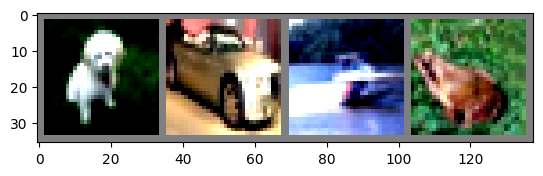

In [11]:
import matplotlib.pyplot as plt

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

## Model

In [12]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()

In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum=0.9)

In [14]:
for epoch in range(2):
    
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        # input data
        inputs, targets = data
        #zero the parameter gradients
        optimizer.zero_grad()
        # forward step 
        outputs = net(inputs)
        loss = loss_fn(outputs, targets)
        # backward step
        loss.backward()
        # update parameters
        optimizer.step()
        
        running_loss += loss.item()
        if i %2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.135
[1,  4000] loss: 1.780
[1,  6000] loss: 1.625
[1,  8000] loss: 1.543
[1, 10000] loss: 1.480
[1, 12000] loss: 1.449
[2,  2000] loss: 1.389
[2,  4000] loss: 1.349
[2,  6000] loss: 1.341
[2,  8000] loss: 1.314
[2, 10000] loss: 1.294
[2, 12000] loss: 1.269
Finished Training


In [19]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %


In [44]:
(l == ind).sum().item()

2